In [1]:
# package(s) related to time, space and id
import datetime, time
import os
import io
import functools
import logging
import pickle
import random
import math

# package(s) related to the simulation
import simpy
import scipy as sc
import networkx as nx  
import numpy as np
import pandas as pd
import re
import yaml as yaml
import matplotlib.pyplot as plt
from scipy import interpolate
from matplotlib.ticker import MaxNLocator
from matplotlib import cm

# OpenTNSim
from opentnsim import core
from opentnsim import plot
from opentnsim import model

# spatial libraries 
import shapely.geometry
import shapely.wkt
import pyproj
import shapely.geometry
import folium
import datetime

# package(s) for data handling
import requests

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

# define the coorinate system
geod = pyproj.Geod(ellps="WGS84")

location_vessel_database = "Vessels/richtlijnen-vaarwegen-2017.csv"

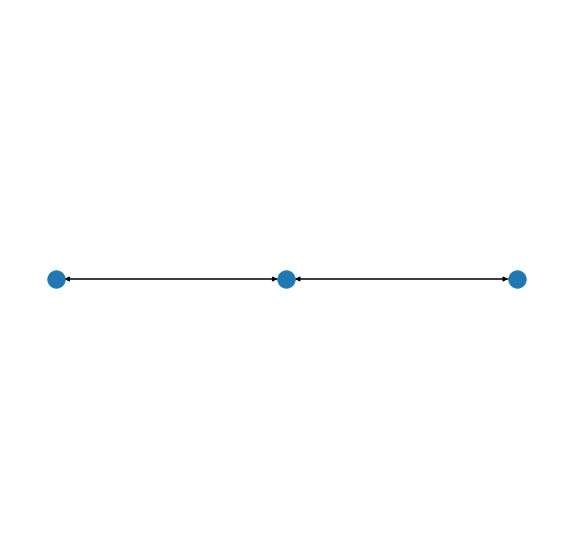

In [2]:
Node = type('Site', (core.Identifiable, core.Log, core.Locatable, core.HasResource), {})
nodes = []
path = []

coords = []
coords.append([0.00,0.00])
coords.append([geod.fwd(coords[0][0],coords[0][1],90,5000)[0],geod.fwd(coords[0][0],coords[0][1],90,5000)[1]])
coords.append([geod.fwd(coords[1][0],coords[1][1],90,5000)[0],geod.fwd(coords[1][0],coords[1][1],90,5000)[1]])

for d in range(len(coords)):
    data_node = {"env": [],
                 "name": "Node " + str(d+1),
                 "geometry": shapely.geometry.Point(coords[d][0], coords[d][1])}
    node = Node(**data_node)
    nodes.append(node)

for i in range(2):
    path.append([nodes[i],nodes[i+1]]) 
    path.append([nodes[i+1],nodes[i]])
    
    FG = nx.DiGraph()

positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

for edge in path:
    FG.add_edge(edge[0].name, edge[1].name, weight = 1)

fig, ax = plt.subplots(figsize=(10, 10))
nx.draw(FG, positions)
plt.axis('equal')
plt.show()

In [3]:
simulation_start = datetime.datetime.now()
sim = model.Simulation(simulation_start,FG)
env = sim.environment

In [4]:
env.FG = FG
terminal = core.IsTerminal(env = env, name = 'Container Terminal 1',length = 500, node_start = 'Node 2', node_end = 'Node 3')
origin = core.IsOrigin(env = env, name = 'generator')

TypeError: __init__() missing 1 required positional argument: 'typ'

In [ ]:
df = pd.DataFrame()
df[0] = ['Container Vessel','Dry Bulk Vessel','Tanker']
df[1] = [366,427,330]
df[2] = [49,55,55]
df[3] = [28,28,28]
df[4] = 0.5*df[3]
df[5] = [66,66,66]
df[6] = df[5]-(df[3]-df[4])
df[7] = [120,120,120]
df[8] = [36*60,72*60,40*60]
df.columns = ['type','L','B','T_f','T_e','H_e','H_f','t_b','t_l']
df

In [ ]:
Vessel = type('Vessel', 
              (core.Identifiable, core.Movable, core.Routeable, core.VesselProperties, core.ExtraMetadata), {})

generator_sea = model.VesselGenerator(Vessel,df)

In [ ]:
origin = 'Node 1'
destination = 'Node 3'
sim.add_vessels(vessel_generator = generator_sea, simulation_start = simulation_start, origin = origin, destination = destination, arrival_distribution = (3600/5000), arrival_process = 'Uniform')

In [ ]:
depth = [[],[]]
width = [[],[]]
water_level = [[],[]]
time = np.linspace(0,135000,1000)
phase_lag = [0,300,600]
depth[1] = [28,28,28]
width[1] = [100,100,100]
for nodes in enumerate(FG.nodes):
    depth[0].append(FG.nodes[nodes[1]]['geometry'])
    width[0].append(FG.nodes[nodes[1]]['geometry'])
    water_level[0].append((FG.nodes[nodes[1]]['geometry']))
    water_level[1].append([[],[]])
    for t in range(len(time)):
        water_level[1][nodes[0]][0].append(time[t]+simulation_start.timestamp())
        water_level[1][nodes[0]][1].append(2.5*np.sin(2*math.pi*time[t]/(45000)-2*phase_lag[nodes[0]]/45000*math.pi))

core.NetworkProperties.append_data_to_nodes(FG,width,depth,water_level)
core.NetworkProperties.append_info_to_edges(FG)

In [ ]:
sim.run(duration = 100000)

In [ ]:
vessels = sim.environment.vessels
env = sim.environment

In [ ]:
vessel = vessels[0]
simulation_start = simulation_start.timestamp()

In [ ]:
def minimum_water_per_edge_as_experienced_by_vessel(vessel):
    network = vessel.env.FG
    route = vessel.route
    min_wdep = [[] for _ in range(len(route)-1)]
    new_t = [[] for _ in range(len(route)-1)]
    distance_to_next_node = 0
    for nodes in enumerate(route):
        if nodes[1] == route[0]:
            wlev_node = network.edges[route[0],route[1]]['Info']['Water level'][1][0]
            depth = network.edges[route[0],route[1]]['Info']['Depth'][0]
            max_wdep = np.max(wlev_node)+depth
            continue

        distance_to_next_node += pyproj.Geod(ellps='WGS84').inv(network.nodes[route[nodes[0]-1]]['geometry'].x,
                                                                network.nodes[route[nodes[0]-1]]['geometry'].y,
                                                                network.nodes[route[nodes[0]]]['geometry'].x,
                                                                network.nodes[route[nodes[0]]]['geometry'].y)[2]

        t_wlev = network.edges[route[nodes[0]-1],route[nodes[0]]]['Info']['Water level'][0]
        sailing_time_to_next_node = distance_to_next_node/vessel.v
        wlev_node1 = network.edges[route[0],route[1]]['Info']['Water level'][1][0]
        depth1 = network.edges[route[0],route[1]]['Info']['Depth'][0]
        wlev_node2 = network.edges[route[nodes[0]-1],route[nodes[0]]]['Info']['Water level'][1][1]
        depth2 = network.edges[route[nodes[0]-1],route[nodes[0]]]['Info']['Depth'][0]
        if np.max([np.max(wlev_node1)+depth1,np.max(wlev_node2)+depth2]) > max_wdep:
            max_wdep = np.max([np.max(wlev_node1),np.max(wlev_node2)])
        interp_wdep_node1 = sc.interpolate.CubicSpline(t_wlev,[y+depth1 for y in wlev_node1])
        eta_next_node = [t-sailing_time_to_next_node for t in t_wlev]
        interp_wdep_node2 = sc.interpolate.CubicSpline(eta_next_node,[y+depth2 for y in wlev_node2])
        new_t[nodes[0]-1] = np.arange(vessel.now,eta_next_node[-1],300) #vessel.env.now
        for t in new_t[nodes[0]-1]:
            min_wdep[nodes[0]-1].append(np.min([interp_wdep_node1(t),interp_wdep_node2(t)]))
    
    time_minimum_water_depth = []
    minimum_water_depth = []
    for t in range(len(new_t[nodes[0]-1])):
        min_water_level = max_wdep
        for edge in range(len(new_t)):
            if min_wdep[edge][t] < min_water_level:
                min_water_depth = min_wdep[edge][t]
        time_minimum_water_depth.append(new_t[edge][t])
        minimum_water_depth.append(min_water_depth)

    return time_minimum_water_depth,minimum_water_depth

network = vessel.env.FG
route = vessel.route
vessel.now = np.min(network.edges[route[nodes[0]-1],route[nodes[0]]]['Info']['Water level'][0])
time = np.linspace(np.min(network.edges[route[nodes[0]-1],route[nodes[0]]]['Info']['Water level'][0]),
                   np.max(network.edges[route[nodes[0]-1],route[nodes[0]]]['Info']['Water level'][0]),1000)
wtime = []

for t in time:
    network = vessel.env.FG
    current_time = t
    route = vessel.route
    ukc = 0.5
    waiting_time = 0
    time_minimum_water_depth,minimum_water_depth = minimum_water_per_edge_as_experienced_by_vessel(vessel)
    water_depth_required = vessel.T_f + ukc
    interp_water_level_at_edge = sc.interpolate.CubicSpline(time_minimum_water_depth, minimum_water_depth)
    root_interp_water_level_at_edge = sc.interpolate.CubicSpline(time_minimum_water_depth,[y - water_depth_required for y in minimum_water_depth])
    water_depth_at_edge = interp_water_level_at_edge(t)
    if water_depth_required > water_depth_at_edge:
        times_edge_is_navigable = root_interp_water_level_at_edge.roots()
        for t2 in times_edge_is_navigable:
            if t2 >= current_time:
                time_edge_is_navigable = t2-current_time
                break
    if time_edge_is_navigable > waiting_time:
        waiting_time = time_edge_is_navigable
            
    wtime.append(waiting_time)

In [ ]:
plt.plot(time_minimum_water_depth,minimum_water_depth)

In [ ]:
fig, ax1 = plt.subplots(figsize=[10,10])

ax1.set_xlabel('time (s)')
ax1.set_ylabel('water level [m]', color='deepskyblue')
ax1.plot([x for x in water_level[1][0][0]],water_level[1][0][1],color='deepskyblue')
ax1.plot([x-5000/4 for x in water_level[1][1][0]],water_level[1][1][1],color='dodgerblue')
ax1.plot([x-10000/4 for x in water_level[1][1][0]],water_level[1][2][1],color='darkblue')
ax1.tick_params(axis='y', labelcolor='deepskyblue')

ax2 = ax1.twinx()

ax2.set_ylabel('waiting time in anchorage [s]', color='r')
ax2.plot(time,wtime,'r')
ax2.tick_params(axis='y', labelcolor='r')

fig.tight_layout() 
plt.xlim([np.min(water_level[1][0][0]),np.max(water_level[1][0][0])])
ax1.axhline(0.5,color = 'k',linestyle = '--')
plt.show()

In [ ]:
water_depth_required = vessel.T_f + ukc
interp_water_level_at_edge = sc.interpolate.CubicSpline(time_minimum_water_depth,minimum_water_depth)
root_interp_water_level_at_edge = sc.interpolate.CubicSpline(time_minimum_water_depth,[y-water_depth_required for y in minimum_water_depth])
root_interp_water_level_at_edge.roots()

In [ ]:
def calculate_available_sail_in_times(vessel):
    available_sail_in_times = []
    vessel.waiting_time_start = vessel.env.now
    vessel.max_waiting_time = vessel.waiting_time_start + 24*60*60
    [new_t,min_wlev] = minimum_water_per_edge_as_experienced_by_vessel(vessel)
    
    def times_tidal_window():
        times_tidal_window = []

        for root in root_interp_water_level_at_edge.roots():
            if root > np.min(new_t[-1]) and root < np.max(new_t[-1]) and min_wlev[-1][np.where(new_t[-1]==new_t[-1][new_t[-1]>root][0])[0][0]] > (water_level_required-depth_of_edge):
                times_tidal_window.append([root,'Stop'])
            elif root > np.min(new_t[-1]) and root < np.max(new_t[-1]) and min_wlev[-1][np.where(new_t[-1]==new_t[-1][new_t[-1]>root][0])[0][0]] < (water_level_required-depth_of_edge):
                times_tidal_window.append([root,'Start'])
        
        return times_tidal_window

    def max_waiting_time_in_anchorage(vessel,times_tidal_window):
        for time in range(len(times_tidal_window)):
            if times_tidal_window[time][0] > vessel.max_waiting_time and times_tidal_window[time][1] == 'Stop':
                break
        if not times_tidal_window or times_tidal_window[time-1][0] > vessel.max_waiting_time:
            max_waiting_time_in_anchorage = vessel.max_waiting_time
        else:
            max_waiting_time_in_anchorage = times_tidal_window[time-1][0]
        return max_waiting_time_in_anchorage
    
    times_tidal_window = times_tidal_window()
    for time in range(len(times_tidal_window)):
        if times_tidal_window[time][0] < max_waiting_time_in_anchorage(vessel,times_tidal_window):
            available_sail_in_times.append(times_tidal_window[time])
            
    available_sail_in_times.insert(0,[vessel.waiting_time_start,'Start'])
    available_sail_in_times.append([max_waiting_time_in_anchorage(vessel,times_tidal_window),'Stop'])
    
    return available_sail_in_times

In [ ]:
def vessel_to_anchorage(vessel,waiting_time_for_tidal_window):
    network = vessel.env.FG
    for n in network.nodes:
        if 'Anchorage' in network.nodes[n]:    
            anchorage = network.nodes[n]['Anchorage'][0]
            break
    
    #Assign new route and origin to vessel
    vessel.route = nx.dijkstra_path(self.env.FG, self.route[self.route.index(destination)],n)
    vessel.geometry = nx.get_node_attributes(self.env.FG, "geometry")[self.route[0]]
    
    #Calculate the distance to the anchorage area
    for nodes in enumerate(vessel.route):
        if nodes[1] == vessel.route[-1]:
            continue
        _,_,distance = vessel.wgs84.inv(vessel.env.FG.nodes[vessel.route[nodes[0]]]['geometry'].x, 
                                        vessel.env.FG.nodes[vessel.route[nodes[0]]]['geometry'].y, 
                                        vessel.env.FG.nodes[vessel.route[nodes[0]+1]]['geometry'].x, 
                                        vessel.env.FG.nodes[vessel.route[nodes[0]+1]]['geometry'].y)
    
    #Determine if vessel is prone to a tidal window
    available_sail_in_times = calculate_available_sail_in_times(vessel)
    
    #Request spot in anchorage
    anchorage.anchorage[n].request()   
    
    #Assign attributes to anchorage user
    anchorage.anchorage[n].users[-1].id = vessel.id
    anchorage.anchorage[n].users[-1].waiting_time_start = available_sail_in_times[0][0]+distance/vessel.v
    anchorage.anchorage[n].users[-1].max_waiting_time = available_sail_in_times[-1][0]
    anchorage.anchorage[n].users[-1].tidal_window = False
    anchorage.anchorage[n].users[-1].sail_in_times = []
    if available_sail_in_times[-2][0]:
        anchorage.anchorage[n].users[-1].tidal_window = True
        anchorage.anchorage[n].users[-1].sail_in_times = available_sail_in_times
    anchorage.anchorage[n].users[-1].length = vessel.L
    anchorage.original_origin = vessel.route[0]
    anchorage.original_destination = [vessel.route[-2],vessel.route[-1]]
    vessel.env.process(self.move(simulation_start))   
    
def access_terminal_directly(vessel):
    terminal = vessel.env.FG.edges[edge]["Terminal"][0]
    terminal.length.get(vessel.L)
    terminal.terminal[edge[0]].request()   
    sailing_distance = 0
    for nodes in enumerate(vessel.route[:-2]):
        _,_,distance = vessel.wgs84.inv(vessel.env.FG.nodes[vessel.route[nodes[0]]]['geometry'].x, 
                                        vessel.env.FG.nodes[vessel.route[nodes[0]]]['geometry'].y, 
                                        vessel.env.FG.nodes[vessel.route[nodes[0]+1]]['geometry'].x, 
                                        vessel.env.FG.nodes[vessel.route[nodes[0]+1]]['geometry'].y)
        sailing_distance += distance
    terminal.terminal[edge[0]].users[-1].eta = vessel.env.now + sailing_distance/vessel.v
    terminal.terminal[edge[0]].users[-1].etd = terminal.terminal[edge[0]].users[-1].eta + 30*60 + 4*3600 + 4*3600 + 10*60
    
def available_length_at_terminal_over_time(terminal):
    terminal_user_info = [[],[]]
    for user in terminal.users:
        terminal_user_info[0].append(user.etd)
        terminal_user_info[1].append(user.L)
    sorted_etds = sorted(enumerate(terminal_user_info[0]),key = max)
    index = [j[0] for j in etds]
    sorted_available_length = [terminal_user_info[1][i] for i in index]
    available_length_at_terminal_over_time = [[],[]]
    for info in range(len(sorted_etds)):
        available_length_at_terminal_over_time[0].append(sorted_etds[info])
        available_length_at_terminal_over_time[1].append(sum(sorted_available_length[0:(info+1)]))
                                                         
    return available_length_at_terminal_over_time

def check_terminal_availability(terminal,vessel):
    available_length_at_terminal_over_time = available_length_at_terminal_over_time(terminal)
    for available_length in available_length_at_terminal_over_time:
        if available_length[0] < available_sail_in_times[t] and available_length[0] > available_sail_in_times[t-1]:
            if available_length[1] < vessel.L:
                continue

            elif available_length[1] > vessel.L:
                for t2 in range(len(available_length_at_terminal_over_time[available_length.index(available_length[1]):])):
                    if available_length_at_terminal_over_time[1][t2] > vessel.L:
                        continue
                    else:
                        length_is_insufficient_due_to_inconsistency_over_time = True
                        break

                    available_length_at_terminal_over_time[available_length.index(available_length[1]):] = [x-1 for x in available_length_at_terminal_over_time[available_length.index(available_length[1]):]]
                    yield vessel.env.timeout(available_length[0]-current_time)
                    terminal.length.get(vessel.L)
                    break

            if length_is_insufficient_due_to_inconsistency_over_time == True:
                if available_length[0] > vessel.max_waiting_time:
                    vessel_turns_back_for_next_port() #Set route
                    break
                else:
                    continue 

In [ ]:
calculate_available_sail_in_times(vessels[0])


In [ ]:
plt.plot(time_minimum_water_depth,[y-water_depth_required for y in minimum_water_depth])
plt.plot(root_interp_water_level_at_edge.roots(),[y for y in np.zeros(len(root_interp_water_level_at_edge.roots()))],'o')

In [ ]:
def move_to_anchorage(anchorage,vessel,waiting_time = 0):
    anchorage.users.append(vessel)
    pass
                
def move_to_terminal(terminal,vessel):
    terminal.users.append(vessel)
    pass                        

In [ ]:
sailing_time_to_anchorage = 1
sailing_time_to_terminal = 1

def reserve_quay_length(vessel,anchorage,terminal,sim):
    sim.simulation_stop = sim.simulation_start + sim.simulation_duration
    length_is_insufficient_due_to_inconsistency_over_time = False
    arrival_time = []
    
    def checks_quay_length_is_consistenly_available_over_time(terminal,vessel,integer_available_length,length_is_insufficient_due_to_inconsistency_over_time = False):
        for t2 in range(len(terminal.available_length_at_terminal_over_time[integer_available_length:])):
            t2 += integer_available_length
            if terminal.available_length_at_terminal_over_time[t2][1] >= vessel.L:
                continue
            else:
                length_is_insufficient_due_to_inconsistency_over_time = True
                break

        return length_is_insufficient_due_to_inconsistency_over_time

    def calculate_departure_integer_time_vessel_at_quay(vessel,sim,arrival_time_vessel_at_quay):
        departure_time_vessel_at_quay = arrival_time_vessel_at_quay+vessel.operation_time
        for t in range(len(vessel.available_sail_out_times)):
            if vessel.available_sail_out_times[t][1] == 'Start':
                continue
            elif t == len(vessel.available_sail_out_times)-1:
                if departure_time_vessel_at_quay <= vessel.available_sail_out_times[-1][0]:
                    break
                else:
                    departure_time_vessel_at_quay = sim.simulation_stop
                break

            if departure_time_vessel_at_quay > vessel.available_sail_out_times[t][0]:
                if departure_time_vessel_at_quay <= vessel.available_sail_out_times[t+1][0]:
                    departure_time_vessel_at_quay = vessel.available_sail_out_times[t+1][0]
                continue
            else:
                break

        for available_length in enumerate(terminal.available_length_at_terminal_over_time):
            if available_length[1][0] >= departure_time_vessel_at_quay:
                break

        departure_integer_time_vessel_at_quay = available_length[0]
        return departure_integer_time_vessel_at_quay,departure_time_vessel_at_quay
    
    for t in range(len(vessel.available_sail_in_times)):
        if t != 0:
            if (vessel.available_sail_in_times[t][0]-vessel.available_sail_in_times[t-1][0]) == sim.simulation_duration-vessel.now:
                vessel.priority = 0
            else:
                vessel.priority = -1
            
        if arrival_time != []:
            break
            
        for available_length in enumerate(terminal.available_length_at_terminal_over_time):
            integer_time_length_is_available = available_length[0]
            previous_integer_time_length_is_available = integer_time_length_is_available-1
            start_time_tidal_window = vessel.available_sail_in_times[t-1][0]
            end_time_tidal_window = vessel.available_sail_in_times[t][0]
            tidal_window_phase = vessel.available_sail_in_times[t][1]
            time_length_is_available = available_length[1][0]
            previous_time_length_is_available = terminal.available_length_at_terminal_over_time[previous_integer_time_length_is_available][0]
            if tidal_window_phase == 'Start':
                continue
                
            if ((time_length_is_available <= end_time_tidal_window and time_length_is_available >= start_time_tidal_window) or
                ((previous_time_length_is_available <= end_time_tidal_window and time_length_is_available >= start_time_tidal_window) and
                 (terminal.available_length_at_terminal_over_time[previous_integer_time_length_is_available][1] >= vessel.L and terminal.available_length_at_terminal_over_time[integer_time_length_is_available][1] >= vessel.L))):
                if available_length[1][1] < vessel.L:
                    continue

                elif available_length[1][1] > vessel.L:
                    if integer_time_length_is_available != 0:
                        checks_quay_length_is_consistenly_available_over_time(terminal,vessel,previous_integer_time_length_is_available)
                    else:
                        checks_quay_length_is_consistenly_available_over_time(terminal,vessel,integer_time_length_is_available)

                if length_is_insufficient_due_to_inconsistency_over_time == True:
                    continue
                    
                if time_length_is_available-vessel.now > vessel.max_waiting_time:
                    move_to_anchorage(anchorage,vessel,waiting_time = vessel.max_waiting_time-sailing_time_to_anchorage)
                    break

                elif length_is_insufficient_due_to_inconsistency_over_time == False:

                    #Reserve quay length
                    if start_time_tidal_window == time_length_is_available:
                        continue_at_integer = previous_integer_time_length_is_available
                        arrival_time = terminal.available_length_at_terminal_over_time[continue_at_integer+1][0]
                        break_at_integer,departure_time = calculate_departure_integer_time_vessel_at_quay(vessel,sim,arrival_time)  
                        for available_length in enumerate(terminal.available_length_at_terminal_over_time):
                            if available_length[0] <= continue_at_integer:
                                continue
                            elif available_length[0] == break_at_integer:
                                break

                            original_length = terminal.available_length_at_terminal_over_time[available_length[0]][1]
                            terminal.available_length_at_terminal_over_time[available_length[0]][1] -= vessel.L

                        if terminal.available_length_at_terminal_over_time[previous_integer_time_length_is_available][0] != departure_time:
                            terminal.available_length_at_terminal_over_time.insert(available_length[0],[departure_time,original_length-vessel.L])
                            terminal.available_length_at_terminal_over_time.insert(available_length[0]+1,[departure_time,original_length])

                    elif previous_time_length_is_available != start_time_tidal_window:
                        if terminal.available_length_at_terminal_over_time[previous_integer_time_length_is_available][1] >= vessel.L:
                            continue_at_integer = integer_time_length_is_available
                            arrival_time = start_time_tidal_window
                            break_at_integer,departure_time = calculate_departure_integer_time_vessel_at_quay(vessel,sim,arrival_time)
                            original_length = terminal.available_length_at_terminal_over_time[previous_integer_time_length_is_available][1]
                            terminal.available_length_at_terminal_over_time.insert(available_length[0],[arrival_time,original_length-vessel.L])
                            break_at_integer += 1
                        else:
                            continue_at_integer = previous_integer_time_length_is_available
                            arrival_time = terminal.available_length_at_terminal_over_time[continue_at_integer+1][0]
                            break_at_integer,departure_time = calculate_departure_integer_time_vessel_at_quay(vessel,sim,arrival_time)

                        for available_length in enumerate(terminal.available_length_at_terminal_over_time):
                            if available_length[0] <= continue_at_integer:
                                continue
                            elif available_length[0] == break_at_integer:
                                break
                            original_length = terminal.available_length_at_terminal_over_time[available_length[0]][1]
                            terminal.available_length_at_terminal_over_time[available_length[0]][1] -= vessel.L

                        if terminal.available_length_at_terminal_over_time[previous_integer_time_length_is_available][0] != departure_time:
                            terminal.available_length_at_terminal_over_time.insert(available_length[0],[departure_time,original_length-vessel.L])
                            terminal.available_length_at_terminal_over_time.insert(available_length[0]+1,[departure_time,original_length])

                    elif previous_time_length_is_available == start_time_tidal_window:
                        continue_at_integer = previous_integer_time_length_is_available
                        arrival_time = terminal.available_length_at_terminal_over_time[continue_at_integer+1][0]
                        break_at_integer,departure_time = calculate_departure_integer_time_vessel_at_quay(vessel,sim,arrival_time)  
                        for available_length in enumerate(terminal.available_length_at_terminal_over_time):
                            if available_length[0] <= continue_at_integer:
                                continue
                            elif available_length[0] == break_at_integer:
                                break

                            original_length = terminal.available_length_at_terminal_over_time[available_length[0]][1]
                            terminal.available_length_at_terminal_over_time[available_length[0]][1] -= vessel.L

                        if terminal.available_length_at_terminal_over_time[previous_integer_time_length_is_available][0] != departure_time:
                            terminal.available_length_at_terminal_over_time.insert(available_length[0],[departure_time,original_length-vessel.L])
                            terminal.available_length_at_terminal_over_time.insert(available_length[0]+1,[departure_time,original_length])
                
            if arrival_time == []:
                [arrival_time, departure_time] = [vessel.now,vessel.now]
                move_to_anchorage(anchorage,vessel,waiting_time = vessel.max_waiting_time-2*sailing_time_to_anchorage)
            elif arrival_time-vessel.now <= sailing_time_to_terminal:
                move_to_terminal(terminal,vessel)
                #access_terminal_directly()
            else:
                move_to_anchorage(anchorage,vessel,waiting_time = arrival_time-vessel.now-2*sailing_time_to_anchorage)
            break
    
    vessel.scheduled_arrival_time = arrival_time
    vessel.scheduled_departure_time = departure_time
    
    return

In [ ]:
class anchorage:
    pass

class sim:
    pass
sim.simulation_start = 0
sim.simulation_duration = 24

class vessel:
    pass

class terminal:
    pass
anchorage.users = []
terminal.users = []
terminal.length = 7
terminal.available_length_at_terminal_over_time = [[0,0],
                                                   [3,2],
                                                   [5,5],
                                                   [8,terminal.length],
                                                   [24,terminal.length]]

In [ ]:
a = [[0,0],[(sim.simulation_start+sim.simulation_duration),0]]

lengths = [2,5]
current_time = [0,0]
max_waiting_time = [12,12]
operation_time = [8,8]
available_sail_in_times = [[[0,'Start'],[24,'Stop']],[[8,'Start'],[12,'Stop'],[20,'Start'],[24,'Stop']]]
available_sail_out_times = [[[0,'Start'],[24,'Stop']],[[8,'Start'],[12,'Stop'],[20,'Start'],[24,'Stop']]]

for v in range(2):
    vessel.L = lengths[v]
    vessel.now = current_time[v]
    vessel.max_waiting_time = max_waiting_time[v]
    vessel.operation_time = operation_time[v]
    vessel.available_sail_in_times = available_sail_in_times[v]
    vessel.available_sail_out_times = available_sail_out_times[v]

    reserve_quay_length(vessel,anchorage,terminal,sim)
    
    for u in anchorage.users:
        if u.priority == -1:
            print(u.priority,u.scheduled_arrival_time,u.scheduled_departure_time)
        else:
            print(u.priority)
        
    print(terminal.available_length_at_terminal_over_time)
    
    if vessel.scheduled_arrival_time == vessel.scheduled_departure_time:
        continue
    
    for i in range(len(a)):
        if vessel.scheduled_arrival_time < a[i][0]:
            if a[i-1][1] != 0:
                terminal.available_length_at_terminal_over_time
            else:
                a.insert(i,[vessel.scheduled_arrival_time,vessel.L])
            break
            
    for j in range(len(a)):
        if vessel.scheduled_departure_time < a[i][0]:
            break
            
    for k in range(len(a[i:j])):
        if k == 0:
            continue  
        a[k+i][1] += vessel.L
    
    for j in range(len(a)):
        if vessel.scheduled_departure_time < a[j][0]:
            if a[j-1][1] != 0:
                a.insert(j,[vessel.scheduled_departure_time,a[j-1][1]-vessel.L])
            else:
                a.insert(j,[vessel.scheduled_departure_time,0])
            break
            
b = []
for i in range(len(a)):
    if i == 0:
        b.append(a[i])
        continue
    
    if a[i-1][1] != a[i][1]:
        b.append([a[i][0],a[i-1][1]])
        
    b.append(a[i])
    
x3 = []
y3 = []
for i in range(len(b)):
    if b[i][0] != 0: 
        x3.append(b[i][0])
        y3.append(b[i-1][1])
    x3.append(b[i][0])
    y3.append(b[i][1])
    
x1 = []
y1 = []
for i in range(len(terminal.available_length_at_terminal_over_time)):
    if terminal.available_length_at_terminal_over_time[i][0] != 0: 
        x1.append(terminal.available_length_at_terminal_over_time[i][0])
        y1.append(terminal.available_length_at_terminal_over_time[i-1][1])
    x1.append(terminal.available_length_at_terminal_over_time[i][0])
    y1.append(terminal.available_length_at_terminal_over_time[i][1])

x2 = []
y2 = []
original_available_length_at_terminal_over_time = [[0,0],
                                                   [3,2],
                                                   [5,5],
                                                   [8,7],
                                                   [24,7]]
for i in range(len(original_available_length_at_terminal_over_time)):
    if original_available_length_at_terminal_over_time[i][0] != 0: 
        x2.append(original_available_length_at_terminal_over_time[i][0])
        y2.append(original_available_length_at_terminal_over_time[i-1][1])
    x2.append(original_available_length_at_terminal_over_time[i][0])
    y2.append(original_available_length_at_terminal_over_time[i][1])

plt.plot(x2,y2)
plt.plot(x1,y1)
plt.plot(x3,y3)

plt.xlim([sim.simulation_start,sim.simulation_stop])
plt.xlabel('Time [units]')
plt.ylim([0,terminal.length+1])
plt.ylabel('Capacity [units]')
plt.legend(['Original Availability','New Availability','Vessel Occupancy'])
plt.show()  